In [1]:
# Importing packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import datetime as dt
from pandas.tseries.offsets import DateOffset
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import os

In [3]:
# Load data 

file_dir = os.path.dirname(os.path.realpath('cross_val_test.ipynb'))
python_dir = os.path.dirname(file_dir)
# speciale_path = os.path.join(python_dir, 'Speciale_Kode')
# temp_path = os.path.join(speciale_path, 'temp')
temp_path = os.path.join(python_dir, 'temp')
data_path = os.path.join(temp_path, 'GenerationProdTypeExchange.csv')

df = pd.read_csv(data_path, sep=';', decimal=',')
df_filtered = df[df['PriceArea'] == 'DK1']
df_DK1 = df_filtered[["TimeDK", "GrossCon"]]
df_DK1 = df_DK1.sort_values(by='TimeDK', ascending=True)
df_DK1.reset_index(drop=True, inplace=True)
df_DK1['TimeDK'] = pd.to_datetime(df_DK1['TimeDK'])
df_DK1['GrossCon'] = df_DK1['GrossCon'].astype(float)

train_set = df_DK1.copy()

# train_set = df_DK1.loc[df_DK1['TimeDK'] < pd.Timestamp('2026-02-07')]
# train_set.reset_index(drop=True, inplace=True)
# test_set = df_DK1.loc[df_DK1['TimeDK'] >= pd.Timestamp('2026-02-07')]
# test_set.reset_index(drop=True, inplace=True)

print(f"Training data shape: {train_set.shape}")
# print(f"Test data shape: {test_set.shape}")
# print(f"Test set fraction: {len(test_set)/len(train_set):.2%}")

Training data shape: (17520, 2)


In [4]:
np.random.seed(42)
torch.manual_seed(42)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    print("Device count:", torch.cuda.device_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA available: True
GPU: NVIDIA GeForce GTX 1660
CUDA version: 12.1
Device count: 1


In [5]:
class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length=24):
        """
        data: numpy array of shape (n_samples,)
        sequence_length: how many past timesteps to use
        """
        self.sequence_length = sequence_length
        self.data = torch.FloatTensor(data).unsqueeze(1)  # Add feature dimension
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        # Get sequence of past values
        x = self.data[idx:idx + self.sequence_length]
        # Target is the next value
        y = self.data[idx + self.sequence_length]
        return x, y

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

In [13]:
def perform_walk_forward_validation_lstm(
    data_series, 
    training_window=1440,  
    forecast_horizon=720,  
    sequence_length=24,   
    hidden_size=64,
    num_layers=2,
    learning_rate=0.001,
    num_epochs=50,
    batch_size=16
):
    """
    Walk-forward validation for PyTorch LSTM.
    """
    all_predictions = []
    all_actuals = []
    fold_errors = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Calculate number of folds
    num_folds = (len(data_series) - training_window - forecast_horizon) // forecast_horizon + 1
    
    print(f"Total folds: {num_folds}")
    print(f"Training window: {training_window} hours")
    print(f"Forecast horizon: {forecast_horizon} hours")
    print(f"Sequence length: {sequence_length} hours\n")
    
    for fold in range(num_folds):
        start = fold * forecast_horizon
        
        # Check if we have enough data
        if start + training_window + forecast_horizon > len(data_series):
            break
            
        print(f"Fold {fold + 1}/{num_folds}")
        
        # Split data
        train_data = data_series[start:start + training_window]
        val_data = data_series[start + training_window:start + training_window + forecast_horizon]
        
        # Standardize using training statistics
        train_mean = train_data.mean()
        train_std = train_data.std()
        
        train_data_scaled = (train_data - train_mean) / train_std
        val_data_scaled = (val_data - train_mean) / train_std
        
        # Create datasets
        train_dataset = SequenceDataset(train_data_scaled, sequence_length)
        val_dataset = SequenceDataset(val_data_scaled, sequence_length)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model for this fold
        model = LSTMModel(
            input_size=1,  # Single feature (GrossCon)
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=1
        ).to(device) 
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop
        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:
                avg_loss = epoch_loss / len(train_loader)
                print(f"  Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        
        # Make predictions - autoregressive
        model.eval()
        predictions = []

        with torch.no_grad():
            # Seed with the last sequence_length hours of real training data
            input_seq = torch.FloatTensor(train_data_scaled[-sequence_length:]).unsqueeze(0).unsqueeze(-1).to(device)
            # Shape: (1, sequence_length, 1)
            
            for step in range(forecast_horizon):
                # Predict next step
                output = model(input_seq)
                next_val = output.squeeze().item()
                predictions.append(next_val)
                
                # Drop oldest timestep, append new prediction
                next_tensor = torch.FloatTensor([[[next_val]]]).to(device)
                input_seq = torch.cat([input_seq[:, 1:, :], next_tensor], dim=1)
        
        # Un-standardize
        predictions = np.array(predictions) * train_std + train_mean
        actuals = np.array(val_data)

        print(f"  Predictions shape: {predictions.shape}")
        print(f"  Actuals shape: {actuals.shape}")
        assert len(predictions) == forecast_horizon, f"Expected {forecast_horizon} predictions, got {len(predictions)}"
        assert len(actuals) == forecast_horizon, f"Expected {forecast_horizon} actuals, got {len(actuals)}"
        
        # Calculate error
        fold_mse = mean_squared_error(actuals, predictions)
        fold_rmse = np.sqrt(fold_mse)
        fold_mae = mean_absolute_error(actuals, predictions)
        
        fold_errors.append(fold_rmse)
        all_predictions.extend(predictions)
        all_actuals.extend(actuals)
        
        print(f"  Fold RMSE: {fold_rmse:.2f}, MAE: {fold_mae:.2f}\n")
    
    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    overall_mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f"Overall RMSE: {overall_rmse:.2f}")
    print(f"Overall MAE: {overall_mae:.2f}")
    print(f"Average Fold RMSE: {np.mean(fold_errors):.2f} (+/- {np.std(fold_errors):.2f})")
    
    return all_predictions, all_actuals, fold_errors

In [8]:
def plot_walk_forward_results(predictions, actuals, training_window=1440, forecast_horizon=720):
    """
    Plot walk-forward validation results.
    """
    plt.figure(figsize=(15, 6))
    
    # Create x-axis (fold numbers repeated for each prediction in that fold)
    x = []
    fold_num = 0
    for i in range(len(predictions)):
        if i % (forecast_horizon) == 0 and i > 0:
            fold_num += 1
        x.append(fold_num)
    
    plt.plot(actuals, label='Actual', alpha=0.7, linewidth=2)
    plt.plot(predictions, label='Predicted', alpha=0.7, linewidth=2)
    
    # Add vertical lines to separate folds
    for i in range(0, len(predictions), forecast_horizon):
        plt.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    plt.xlabel('Time Step')
    plt.ylabel('Gross Consumption')
    plt.title('Walk-Forward Validation: Predicted vs Actual')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Using device: cuda
Total folds: 95
Training window: 1440 hours
Forecast horizon: 168 hours
Sequence length: 24 hours

Fold 1/95
  Epoch 10/50, Loss: 0.0651
  Epoch 20/50, Loss: 0.0526
  Epoch 30/50, Loss: 0.0510
  Epoch 40/50, Loss: 0.0464
  Epoch 50/50, Loss: 0.0424
  Predictions shape: (168,)
  Actuals shape: (168,)
  Fold RMSE: 573.02, MAE: 492.45

Fold 2/95
  Epoch 10/50, Loss: 0.0613
  Epoch 20/50, Loss: 0.0540
  Epoch 30/50, Loss: 0.0507
  Epoch 40/50, Loss: 0.0497
  Epoch 50/50, Loss: 0.0464
  Predictions shape: (168,)
  Actuals shape: (168,)
  Fold RMSE: 300.72, MAE: 251.45

Fold 3/95
  Epoch 10/50, Loss: 0.0683
  Epoch 20/50, Loss: 0.0599
  Epoch 30/50, Loss: 0.0567
  Epoch 40/50, Loss: 0.0527
  Epoch 50/50, Loss: 0.0454
  Predictions shape: (168,)
  Actuals shape: (168,)
  Fold RMSE: 432.74, MAE: 356.11

Fold 4/95
  Epoch 10/50, Loss: 0.0678
  Epoch 20/50, Loss: 0.0582
  Epoch 30/50, Loss: 0.0555
  Epoch 40/50, Loss: 0.0528
  Epoch 50/50, Loss: 0.0503
  Predictions shape: (16

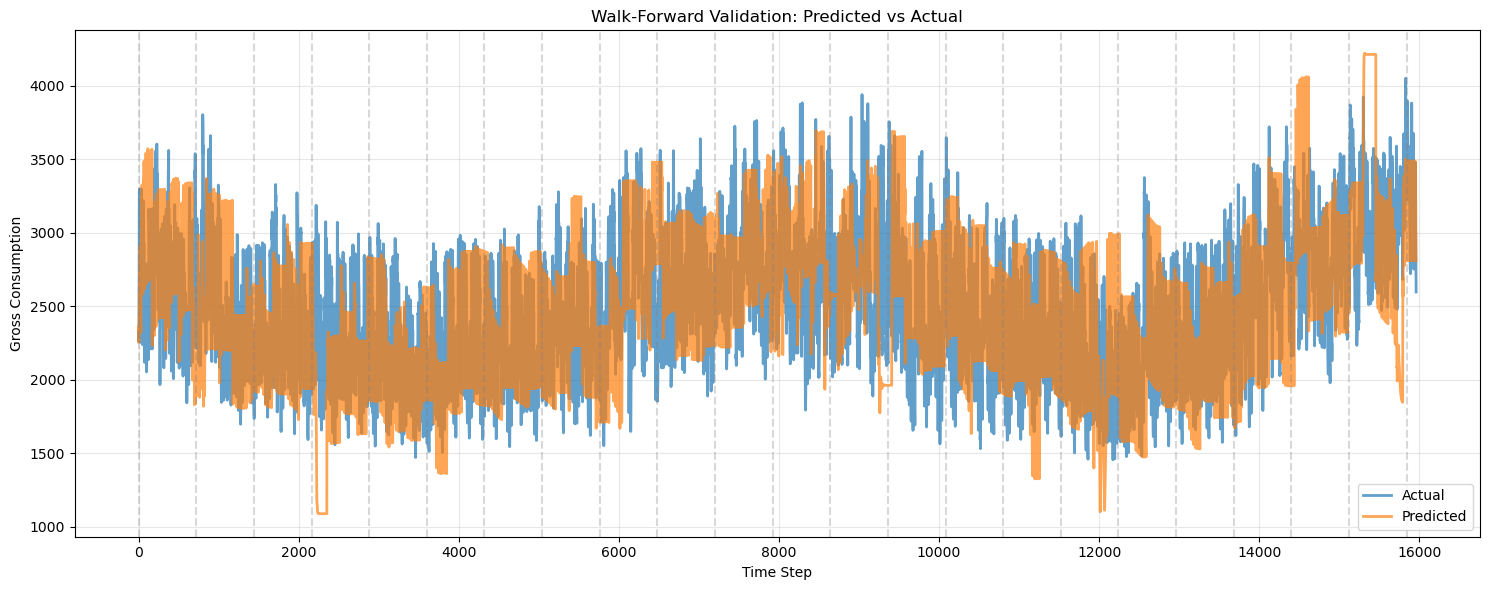

In [14]:
predictions, actuals, fold_errors = perform_walk_forward_validation_lstm(
    data_series=train_set['GrossCon'].values,
    training_window=1440,  
    forecast_horizon=168,  
    sequence_length=24,   
    hidden_size=64,
    num_layers=2,
    learning_rate=0.001,
    num_epochs=50,
    batch_size=16
)

# Plot results
plot_walk_forward_results(predictions, actuals)